# Capstone Project - The Battle of Neighborhoods
***
## Coffee Shops in Toronto

## Introduction
For most people, coffee is essential to start the day. Many people will enjoy a cup of coffee for works or study, while Toronto is Canada's busiest business hub. 

This project explores which neighborhoods of Toronto have the most coffee shop. Additionally, I will attempt to answer the questions "Where should I open a coffee shop to succeed?"

### Target Audience
Below clients or people would interested in this project:

> Business personnel who wants to invest or open a coffee shop. This analysis will be a guide to start or expand restaurants targeting tourists and lovers of coffee.

### Data
In order to answer the above questions, data on Toronto neighborhoods including geocoordinates and information related to poutine restaurants.   
  
The neighborhood data is not readily available on the internet. We will first scrape the following Wikipedia page,  https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, and then include the geocoordinates of each neighborhood by downloading the geographical coordinates of each postal from http://cocl.us/Geospatial_data.


All data related to locations and quality of coffee shops will be obtained via the FourSquare API utilized via the Request library in Python.

### 1. Data Preparation and Preprocessing

#### Task 1: Data Collection

Import all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from bs4 import BeautifulSoup # scrap data from web

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
# Extract data
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
raw = BeautifulSoup(url, 'lxml')
raw

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of postal codes of Canada: M - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"Xm3ZJwpAMFgAAKafFiIAAAAU","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":945633050,"wgRevisionId":945633050,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short descr

After observing carefully the HTML script, the data is under class Wikitable Sortable. 

In [3]:
My_table = raw.find('table')#,{'class':'wikitable sortable'})
My_table

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North

In [4]:
# extract all the values within <tr>
postal_table = ""
for tr in My_table.find_all('tr'):
    row1 = ""
    for tds in tr.find_all('td'):
        row1 = row1 + "," + tds.text
    postal_table = postal_table+row1[1:]
print(postal_table)

M1A,Not assigned,Not assigned
M2A,Not assigned,Not assigned
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,Harbourfront
M6A,North York,Lawrence Heights
M6A,North York,Lawrence Manor
M7A,Downtown Toronto,Queen's Park
M8A,Not assigned,Not assigned
M9A,Etobicoke,Islington Avenue
M1B,Scarborough,Rouge
M1B,Scarborough,Malvern
M2B,Not assigned,Not assigned
M3B,North York,Don Mills North
M4B,East York,Woodbine Gardens
M4B,East York,Parkview Hill
M5B,Downtown Toronto,Ryerson
M5B,Downtown Toronto,Garden District
M6B,North York,Glencairn
M7B,Not assigned,Not assigned
M8B,Not assigned,Not assigned
M9B,Etobicoke,Cloverdale
M9B,Etobicoke,Islington
M9B,Etobicoke,Martin Grove
M9B,Etobicoke,Princess Gardens
M9B,Etobicoke,West Deane Park
M1C,Scarborough,Highland Creek
M1C,Scarborough,Rouge Hill
M1C,Scarborough,Port Union
M2C,Not assigned,Not assigned
M3C,North York,Flemingdon Park
M3C,North York,Don Mills South
M4C,East York,Woodbine Heights
M5C,Downtown Toronto,St. James

In [5]:
# Save the data as csv file.
file = open("toronto_postal.csv", "wb")
file.write(bytes(postal_table,encoding="ascii",errors="ignore"))

8709

In [6]:
# Create a dataframe
df_raw = pd.read_csv('toronto_postal.csv', header = None)
df_raw.columns = ['Postal Code', 'Borough', 'Neighborhood']
print(df_raw.shape)
df_raw.head()

(287, 3)


,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


##### Data preprocessing

In [7]:
# Create a copy of raw to clean the data
df_clean = df_raw.copy()
df_clean.head(15)

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Etobicoke,Islington Avenue


Droping rows where borough is "Not assigned"

In [8]:
# Get the unassigned postal code
index_na = df_raw[df_raw['Borough'] == 'Not assigned'].index

# Drop the rows with unassigned postal code
df_clean.drop(index_na, inplace = True)
df_clean.head(15)

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


Assigning "Neighborhood" to "Borough" if "Neighborhood" is unassigned.

In [9]:
df_clean.loc[df_clean['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df_clean['Borough']
df_clean.head(15)

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


Combining common postal code with the neighborhoods separated with a comma.

In [10]:
result = df_clean.groupby(['Postal Code','Borough'], sort=False).agg( ', '.join)
df_clean = result.reset_index()
df_clean.head(15)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [11]:
df_clean.shape

(103, 3)

#### Task 2: Add Geographical Coordinates of the Neighborhoods

In order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. We will download the geographical coordinates of each postal code from http://cocl.us/Geospatial_data

In [12]:
# Read csv file
geo = pd.read_csv("http://cocl.us/Geospatial_data")
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
neighborhoods = pd.merge(df_clean,
                 geo[['Postal Code','Latitude', 'Longitude']],
                 on='Postal Code')
neighborhoods.head(15)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


In [14]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


#### Define Foursquare Credentials and Version

In [15]:
CLIENT_ID = '3OTBE0GB1WNLBXCUQ33UTSUIOE0XNSXGIBQNZRIEK2O325IJ' # your Foursquare ID
CLIENT_SECRET = '1EZATQKW0VZ14ZJJG3CKJOXP3HCZQOTF4OESKV0IIHG0C3IR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3OTBE0GB1WNLBXCUQ33UTSUIOE0XNSXGIBQNZRIEK2O325IJ
CLIENT_SECRET:1EZATQKW0VZ14ZJJG3CKJOXP3HCZQOTF4OESKV0IIHG0C3IR


### 2. Data Exploration

#### Use geopy library to get the latitude and longitude values of Toronto.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>trt_explorer</em>, as shown below.

In [16]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="trt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [17]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Number of neighborhoods in each borough

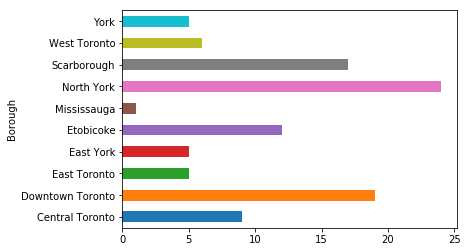

In [18]:
neighborhoods.groupby('Borough')['Neighborhood'].count().plot.barh()

### 3. Data Modeling

In [19]:
def get_venues(lat,lng):
    #set variables
    radius=500
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [20]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
coffee_shop=pd.DataFrame(columns=column_names)
count=1
for row in neighborhoods.values.tolist():
    PostalCode, Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    coffe_shop=venues[venues['Category']=='Coffee Shop']   
    print('(',count,'/',len(neighborhoods),')','Cofee Shop in '+Neighborhood+', '+Borough+':'+str(len(coffee_shop)))
    print(row)
    for resturant_detail in coffe_shop.values.tolist():
        id, name , category=resturant_detail
        coffee_shop = coffee_shop.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'Postal Code': PostalCode,
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Cofee Shop in Parkwoods, North York:0
['M3A', 'North York', 'Parkwoods', 43.7532586, -79.3296565]
( 2 / 103 ) Cofee Shop in Victoria Village, North York:0
['M4A', 'North York', 'Victoria Village', 43.725882299999995, -79.31557159999998]
( 3 / 103 ) Cofee Shop in Harbourfront, Downtown Toronto:1
['M5A', 'Downtown Toronto', 'Harbourfront', 43.6542599, -79.3606359]
( 4 / 103 ) Cofee Shop in Lawrence Heights, Lawrence Manor, North York:9
['M6A', 'North York', 'Lawrence Heights, Lawrence Manor', 43.718517999999996, -79.46476329999999]
( 5 / 103 ) Cofee Shop in Queen's Park, Downtown Toronto:10
['M7A', 'Downtown Toronto', "Queen's Park", 43.6623015, -79.3894938]
( 6 / 103 ) Cofee Shop in Islington Avenue, Etobicoke:19
['M9A', 'Etobicoke', 'Islington Avenue', 43.6678556, -79.53224240000002]
( 7 / 103 ) Cofee Shop in Rouge, Malvern, Scarborough:19
['M1B', 'Scarborough', 'Rouge, Malvern', 43.806686299999996, -79.19435340000001]
( 8 / 103 ) Cofee Shop in Don Mills North, North York:1

( 56 / 103 ) Cofee Shop in Bedford Park, Lawrence Manor East, North York:131
['M5M', 'North York', 'Bedford Park, Lawrence Manor East', 43.7332825, -79.4197497]
( 57 / 103 ) Cofee Shop in Del Ray, Keelesdale, Mount Dennis, Silverthorn, York:133
['M6M', 'York', 'Del Ray, Keelesdale, Mount Dennis, Silverthorn', 43.6911158, -79.47601329999999]
( 58 / 103 ) Cofee Shop in Emery, Humberlea, North York:134
['M9M', 'North York', 'Emery, Humberlea', 43.7247659, -79.53224240000002]
( 59 / 103 ) Cofee Shop in Birch Cliff, Cliffside West, Scarborough:134
['M1N', 'Scarborough', 'Birch Cliff, Cliffside West', 43.692657000000004, -79.2648481]
( 60 / 103 ) Cofee Shop in Willowdale South, North York:134
['M2N', 'North York', 'Willowdale South', 43.7701199, -79.40849279999999]
( 61 / 103 ) Cofee Shop in Downsview Northwest, North York:136
['M3N', 'North York', 'Downsview Northwest', 43.7616313, -79.52099940000001]
( 62 / 103 ) Cofee Shop in Lawrence Park, Central Toronto:136
['M4N', 'Central Toronto', '

In [21]:
coffee_shop.to_csv('coffee_shop.csv', index = False)

In [22]:
coffee_shop = pd.read_csv('coffee_shop.csv')
coffee_shop.head()

,Borough,Neighborhood,ID,Name,Postal Code
0,North York,Victoria Village,4bbe904a85fbb713420d7167,Tim Hortons,M4A
1,Downtown Toronto,Harbourfront,53b8466a498e83df908c3f21,Tandem Coffee,M5A
2,Downtown Toronto,Harbourfront,51853a73498e4d97a8b20831,Rooster Coffee,M5A
3,Downtown Toronto,Harbourfront,57cd9d20498e6ab8342980e2,Arvo,M5A
4,Downtown Toronto,Harbourfront,5619551a498e9e35fce2256b,Sumach Espresso,M5A


In [23]:
coffee_shop = pd.merge(coffee_shop,
                 geo[['Postal Code','Latitude', 'Longitude']],
                 on='Postal Code')
coffee_shop

,Borough,Neighborhood,ID,Name,Postal Code,Latitude,Longitude
0,North York,Victoria Village,4bbe904a85fbb713420d7167,Tim Hortons,M4A,43.725882,-79.315572
1,Downtown Toronto,Harbourfront,53b8466a498e83df908c3f21,Tandem Coffee,M5A,43.654260,-79.360636
2,Downtown Toronto,Harbourfront,51853a73498e4d97a8b20831,Rooster Coffee,M5A,43.654260,-79.360636
3,Downtown Toronto,Harbourfront,57cd9d20498e6ab8342980e2,Arvo,M5A,43.654260,-79.360636
4,Downtown Toronto,Harbourfront,5619551a498e9e35fce2256b,Sumach Espresso,M5A,43.654260,-79.360636
5,Downtown Toronto,Harbourfront,58c7fbf7424f9373e6427e99,Starbucks,M5A,43.654260,-79.360636
6,Downtown Toronto,Harbourfront,581258b738fa5bbefe4c0857,Dark Horse Espresso Bar,M5A,43.654260,-79.360636
7,Downtown Toronto,Harbourfront,4b2cf78cf964a52077cb24e3,Savoury Grounds,M5A,43.654260,-79.360636
8,Downtown Toronto,Harbourfront,57dd8bcd498e8eec19b9c896,FUEL+,M5A,43.654260,-79.360636
9,North York,"Lawrence Heights, Lawrence Manor",4fa4ae40e4b02443361f27c4,Tim Hortons,M6A,43.718518,-79.464763


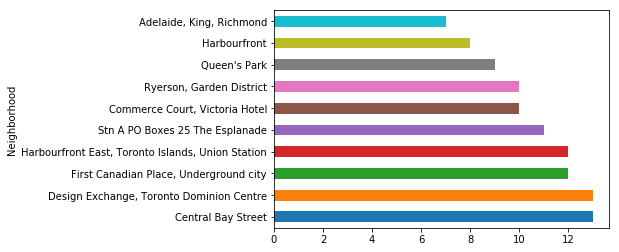

In [24]:
top = 10
coffee_shop.groupby('Neighborhood')['ID'].count().nlargest(top).plot.barh()

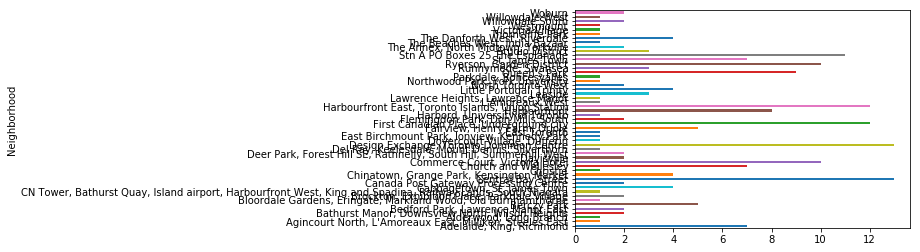

In [25]:
coffee_shop.groupby('Neighborhood')['ID'].count().plot.barh()

In [26]:
borough = coffee_shop['Borough'].value_counts()
borough

Downtown Toronto    135
North York           17
West Toronto         11
Central Toronto       8
East Toronto          8
Scarborough           5
East York             5
Etobicoke             3
Mississauga           2
York                  1
Name: Borough, dtype: int64

Text(0, 0.5, 'Borough')

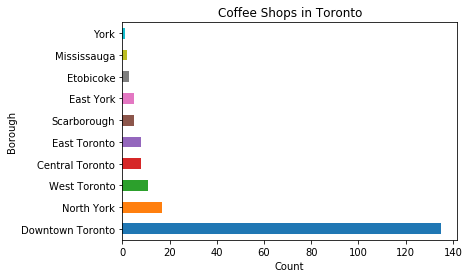

In [27]:
borough.plot.barh()
plt.title("Coffee Shops in Toronto")
plt.xlabel("Count")
plt.ylabel("Borough")

In [28]:
dttor = coffee_shop[coffee_shop['Borough'] == 'Downtown Toronto']
rslt_df = dttor['Neighborhood'].value_counts()
rslt_df

Design Exchange, Toronto Dominion Centre                                                                      13
Central Bay Street                                                                                            13
First Canadian Place, Underground city                                                                        12
Harbourfront East, Toronto Islands, Union Station                                                             12
Stn A PO Boxes 25 The Esplanade                                                                               11
Ryerson, Garden District                                                                                      10
Commerce Court, Victoria Hotel                                                                                10
Queen's Park                                                                                                   9
Harbourfront                                                                                    

Text(0, 0.5, 'Neighborhood')

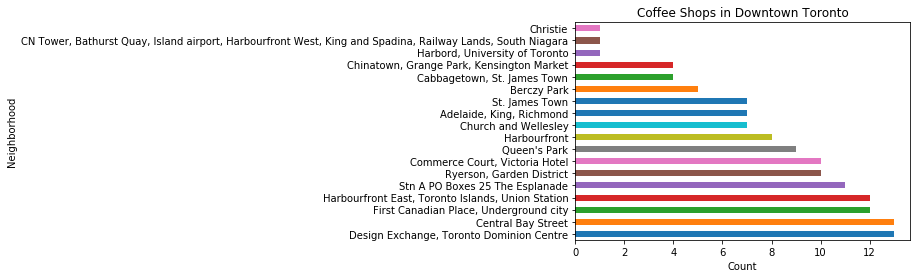

In [29]:
rslt_df.plot.barh()
plt.title("Coffee Shops in Downtown Toronto")
plt.xlabel("Count")
plt.ylabel("Neighborhood")

A heatmap is created to visualize the desnity of the coffee shops in different boroughs.

In [30]:
borough = coffee_shop['Borough'].unique()
color_table = pd.DataFrame({'Borough': borough, 
               'Color': ['red','blue','gray','orange','green','lightgreen','lightblue','purple','pink','cadetblue']})
color_table

,Borough,Color
0,North York,red
1,Downtown Toronto,blue
2,Etobicoke,gray
3,Scarborough,orange
4,East York,green
5,West Toronto,lightgreen
6,East Toronto,lightblue
7,York,purple
8,Central Toronto,pink
9,Mississauga,cadetblue


In [31]:
coffee_shop = pd.merge(coffee_shop,
                 color_table[['Borough','Color']],
                 on='Borough')
coffee_shop

,Borough,Neighborhood,ID,Name,Postal Code,Latitude,Longitude,Color
0,North York,Victoria Village,4bbe904a85fbb713420d7167,Tim Hortons,M4A,43.725882,-79.315572,red
1,North York,"Lawrence Heights, Lawrence Manor",4fa4ae40e4b02443361f27c4,Tim Hortons,M6A,43.718518,-79.464763,red
2,North York,"Flemingdon Park, Don Mills South",4bec7af349430f4760c807d2,Tim Hortons,M3C,43.725900,-79.340923,red
3,North York,"Flemingdon Park, Don Mills South",4b4b7b51f964a520749d26e3,Delimark Cafe,M3C,43.725900,-79.340923,red
4,North York,"Bathurst Manor, Downsview North, Wilson Heights",4b05f2bef964a52064e622e3,Starbucks,M3H,43.754328,-79.442259,red
5,North York,"Bathurst Manor, Downsview North, Wilson Heights",5011603fe4b07c3cf1967fba,Tim Hortons,M3H,43.754328,-79.442259,red
6,North York,"Fairview, Henry Farm, Oriole",50bceb3ae4b01dc9b287cc99,Aroma Espresso Bar,M2J,43.778517,-79.346556,red
7,North York,"Fairview, Henry Farm, Oriole",4af5d36ef964a52062fd21e3,Starbucks,M2J,43.778517,-79.346556,red
8,North York,"Fairview, Henry Farm, Oriole",502fc355e4b0b49bb5791038,Tim Hortons,M2J,43.778517,-79.346556,red
9,North York,"Fairview, Henry Farm, Oriole",5567bf49498e711ea9c1f3fd,Tim Hortons,M2J,43.778517,-79.346556,red


In [32]:
from folium.plugins import HeatMap
m=folium.Map(location=[latitude, longitude],zoom_start=11)
location_data = coffee_shop[['Latitude', 'Longitude']]
# plot heatmap
HeatMap(data=location_data[['Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13)
m.add_child(HeatMap(location_data, radius=15))
    
m

In [33]:
fmap=folium.Map(location=[latitude, longitude],zoom_start=11)
location_data = coffee_shop[['Latitude', 'Longitude']]
for lat,lan,bor,colr in zip(coffee_shop['Latitude'],coffee_shop['Longitude'],coffee_shop['Neighborhood'], coffee_shop['Color']): 
    folium.Marker(location=[lat,lan], popup = bor, icon=folium.Icon(color=colr)).add_to(fmap) 
    
fmap

### 4. Results

Most of the coffee shops in Toronto are located in the borough of Downtown Toronto. The borough with the second most number of coffee shops is North York. Yet, the number of coffee shops in North York is 8 times less than that in Downtown Toronto. North York has only 17 coffee shops, while Downtown Toronto has more than 130. It is believed that Downtown Toronto area is the financial hub, and many companies have their offices located in the area. Hence, the number coffee shops in the area is significantly higher than other areas. Due to the huge competition, Downtown Toronto would not be the best choice if starting/expanding a coffee shop business.

Base on the analysis above and the Census of Population of Canada in 2016, the best place to start/expand a coffee shop business is in Scarborough (the orange area). Scarborough has limited number of coffee shops, yet, the second largest number of population in the borough included in this study. 